# Part 3 - texto

- maior/menor louvor
- word length (maybe)
- bag-of-words with frequency
- gensim corpus
- tf-idf
- named entity recognition (spacy or polyglot)
- next: category classification for avulsos

## Maior e menor louvor

In [64]:
import pandas as pd

hinos_analise = pd.read_pickle("assets\\hinos_analise.pkl")
hinos_analise = hinos_analise.set_index("numero")
hinos_analise["categoria_abr"] = hinos_analise["categoria"].apply(
    lambda x: x[:13] + "..." if len(x) > 15 else x
)
hinos_analise

,nome,texto,texto_limpo,categoria_id,categoria,categoria_abr
numero,,,,,,
0,AQUILO QUE FUI NÃO SOU MAIS,"AQUILO QUE FUI NÃO SOU MAIS,\nNEM SOU TUDO O Q...","AQUILO QUE FUI NÃO SOU MAIS, NEM SOU TUDO O QU...",1,CLAMOR,CLAMOR
1,O SANGUE DE JESUS TEM PODER,"O SANGUE DE JESUS TEM PODER,\nPODER QUE A MIM ...","O SANGUE DE JESUS TEM PODER, PODER QUE A MIM P...",1,CLAMOR,CLAMOR
2,O SANGUE DE JESUS TEM PODER PARA SALVAR,O SANGUE DE JESUS TEM PODER (2x)\nO SANGUE DE ...,O SANGUE DE JESUS TEM PODER O SANGUE DE JESUS...,1,CLAMOR,CLAMOR
3,CLAMO A TI,"CLAMO A TI, Ó MEU SENHOR,\nCLAMO A TI, MEU SAL...","CLAMO A TI, Ó MEU SENHOR, CLAMO A TI, MEU SALV...",1,CLAMOR,CLAMOR
4,QUANDO TE PROSTRARES,"QUANDO TE PROSTRARES DIANTE DE DEUS,\nLEMBRA Q...","QUANDO TE PROSTRARES DIANTE DE DEUS, LEMBRA QU...",1,CLAMOR,CLAMOR
...,...,...,...,...,...,...
790,AQUELE QUE HABITA NO ESCONDERIJO,AQUELE QUE HABITA\nNO ESCONDERIJO DO ALTÍSSIMO...,AQUELE QUE HABITA NO ESCONDERIJO DO ALTÍSSIMO ...,11,CORINHOS,CORINHOS
791,EU QUERO MAIS E MAIS DE CRISTO,EU QUERO MAIS E MAIS DE CRISTO. \nEU QUERO MAI...,EU QUERO MAIS E MAIS DE CRISTO. EU QUERO MAIS ...,11,CORINHOS,CORINHOS
792,LOUVANDO A DEUS,LOUVANDO A DEUS \nE CAINDO NA GRAÇA DE TODO O ...,LOUVANDO A DEUS E CAINDO NA GRAÇA DE TODO O PO...,11,CORINHOS,CORINHOS


In [86]:
import nltk
from tqdm import tqdm

nltk.download("stopwords")

stopwords = nltk.corpus.stopwords.words("portuguese")
stopwords.extend(["ó", "ti", "pra", "lo", "oh"])
text = []
text_no_stops = []

for hino in tqdm(hinos_analise.to_dict("records")):
    tokens = nltk.tokenize.regexp_tokenize(hino["texto_limpo"], r"\w+")
    # Replace "MINH" with "MINHA" with regex
    tokens = [nltk.re.sub(r"^MINH$", "MINHA", palavra) for palavra in tokens]
    tokens = [
        palavra for palavra in tokens if palavra != "CORO" and palavra != "INSTRUMENTOS"
    ]
    tokens_no_stops = [
        palavra for palavra in tokens if palavra.lower() not in stopwords
    ]
    text.append(tokens)
    text_no_stops.append(tokens_no_stops)

hinos_analise["tokens"] = text
hinos_analise["tokens_no_stops"] = text_no_stops
# considerando numero total de palavras, pois todas elas tem que ser cantadas, logo impactam no tamanho prático do hino
hinos_analise["num_tokens"] = hinos_analise["tokens"].apply(len)
hinos_analise

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ISSE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 795/795 [00:00<00:00, 2827.40it/s]


,nome,texto,texto_limpo,categoria_id,categoria,categoria_abr,tokens,tokens_no_stops,num_tokens
numero,,,,,,,,,
0,AQUILO QUE FUI NÃO SOU MAIS,"AQUILO QUE FUI NÃO SOU MAIS,\nNEM SOU TUDO O Q...","AQUILO QUE FUI NÃO SOU MAIS, NEM SOU TUDO O QU...",1,CLAMOR,CLAMOR,"[AQUILO, QUE, FUI, NÃO, SOU, MAIS, NEM, SOU, T...","[TUDO, DEVO, GRAÇA, VÊ, CERTO, VOU, GLÓRIA, CR...",96
1,O SANGUE DE JESUS TEM PODER,"O SANGUE DE JESUS TEM PODER,\nPODER QUE A MIM ...","O SANGUE DE JESUS TEM PODER, PODER QUE A MIM P...",1,CLAMOR,CLAMOR,"[O, SANGUE, DE, JESUS, TEM, PODER, PODER, QUE,...","[SANGUE, JESUS, PODER, PODER, MIM, PODE, VALER...",79
2,O SANGUE DE JESUS TEM PODER PARA SALVAR,O SANGUE DE JESUS TEM PODER (2x)\nO SANGUE DE ...,O SANGUE DE JESUS TEM PODER O SANGUE DE JESUS...,1,CLAMOR,CLAMOR,"[O, SANGUE, DE, JESUS, TEM, PODER, O, SANGUE, ...","[SANGUE, JESUS, PODER, SANGUE, JESUS, SANGUE, ...",50
3,CLAMO A TI,"CLAMO A TI, Ó MEU SENHOR,\nCLAMO A TI, MEU SAL...","CLAMO A TI, Ó MEU SENHOR, CLAMO A TI, MEU SALV...",1,CLAMOR,CLAMOR,"[CLAMO, A, TI, Ó, MEU, SENHOR, CLAMO, A, TI, M...","[CLAMO, SENHOR, CLAMO, SALVADOR, SANGUE, VIDA,...",45
4,QUANDO TE PROSTRARES,"QUANDO TE PROSTRARES DIANTE DE DEUS,\nLEMBRA Q...","QUANDO TE PROSTRARES DIANTE DE DEUS, LEMBRA QU...",1,CLAMOR,CLAMOR,"[QUANDO, TE, PROSTRARES, DIANTE, DE, DEUS, LEM...","[PROSTRARES, DIANTE, DEUS, LEMBRA, JESUS, CONT...",52
...,...,...,...,...,...,...,...,...,...
790,AQUELE QUE HABITA NO ESCONDERIJO,AQUELE QUE HABITA\nNO ESCONDERIJO DO ALTÍSSIMO...,AQUELE QUE HABITA NO ESCONDERIJO DO ALTÍSSIMO ...,11,CORINHOS,CORINHOS,"[AQUELE, QUE, HABITA, NO, ESCONDERIJO, DO, ALT...","[HABITA, ESCONDERIJO, ALTÍSSIMO, SOMBRA, SENHO...",43
791,EU QUERO MAIS E MAIS DE CRISTO,EU QUERO MAIS E MAIS DE CRISTO. \nEU QUERO MAI...,EU QUERO MAIS E MAIS DE CRISTO. EU QUERO MAIS ...,11,CORINHOS,CORINHOS,"[EU, QUERO, MAIS, E, MAIS, DE, CRISTO, EU, QUE...","[QUERO, CRISTO, QUERO, PODER, QUERO, PRESENÇA,...",46
792,LOUVANDO A DEUS,LOUVANDO A DEUS \nE CAINDO NA GRAÇA DE TODO O ...,LOUVANDO A DEUS E CAINDO NA GRAÇA DE TODO O PO...,11,CORINHOS,CORINHOS,"[LOUVANDO, A, DEUS, E, CAINDO, NA, GRAÇA, DE, ...","[LOUVANDO, DEUS, CAINDO, GRAÇA, TODO, POVO, TO...",29


In [87]:
display(hinos_analise.sort_values("num_tokens", ascending=False))
display(hinos_analise.sort_values("num_tokens", ascending=True))

,nome,texto,texto_limpo,categoria_id,categoria,categoria_abr,tokens,tokens_no_stops,num_tokens
numero,,,,,,,,,
731,SEQUÊNCIA DE LOUVORES Nº 1,"A\nDESDE O DIA EM QUE ACEITEI JESUS,\nA MINHA ...","A DESDE O DIA EM QUE ACEITEI JESUS, A MINHA VI...",11,CORINHOS,CORINHOS,"[A, DESDE, O, DIA, EM, QUE, ACEITEI, JESUS, A,...","[DESDE, DIA, ACEITEI, JESUS, VIDA, TRANSFORMOU...",261
364,DÁ-ME MAIS FÉ,DÁ-ME MAIS FÉ PRA QUE O MEU CHORO\nSOMENTE EST...,DÁ-ME MAIS FÉ PRA QUE O MEU CHORO SOMENTE ESTA...,5,CONSOLO E ENCORAJAMENTO,CONSOLO E ENC...,"[DÁ, ME, MAIS, FÉ, PRA, QUE, O, MEU, CHORO, SO...","[DÁ, FÉ, CHORO, SOMENTE, NOITE, POSSA, DURAR, ...",235
466,EIS O ESTANDARTE,"EIS O ESTANDARTE TREMULANDO À LUZ,\nEIS A SUA ...","EIS O ESTANDARTE TREMULANDO À LUZ, EIS A SUA D...",6,SANTIFICAÇÃO E DERRAMAMENTO DO ESPÍRITO SANTO,SANTIFICAÇÃO ...,"[EIS, O, ESTANDARTE, TREMULANDO, À, LUZ, EIS, ...","[EIS, ESTANDARTE, TREMULANDO, LUZ, EIS, DIVISA...",226
707,"EU CONFIO EM TI, SENHOR","EU CONFIO EM TI, SENHOR!\nMESMO QUANDO TUDO NÃ...","EU CONFIO EM TI, SENHOR! MESMO QUANDO TUDO NÃO...",10,GRUPO DE LOUVOR,GRUPO DE LOUVOR,"[EU, CONFIO, EM, TI, SENHOR, MESMO, QUANDO, TU...","[CONFIO, SENHOR, TUDO, VAI, BEM, ESPERANÇA, FU...",207
371,TODA PROMESSA,"TODA PROMESSA, TODA PALAVRA QUE O SENHOR FALOU...","TODA PROMESSA, TODA PALAVRA QUE O SENHOR FALOU...",5,CONSOLO E ENCORAJAMENTO,CONSOLO E ENC...,"[TODA, PROMESSA, TODA, PALAVRA, QUE, O, SENHOR...","[TODA, PROMESSA, TODA, PALAVRA, SENHOR, FALOU,...",189
...,...,...,...,...,...,...,...,...,...
192,"JESUS, JESUS, EU TE AMO","JESUS, JESUS, EU TE AMO,\nÓ MEU SALVADOR;\nEU ...","JESUS, JESUS, EU TE AMO, Ó MEU SALVADOR; EU TE...",3,DEDICAÇÃO,DEDICAÇÃO,"[JESUS, JESUS, EU, TE, AMO, Ó, MEU, SALVADOR, ...","[JESUS, JESUS, AMO, SALVADOR, QUERO, ESPERO, S...",18
738,"GLÓRIA, GLÓRIA","GLÓRIA, GLÓRIA, GLÓRIA \nAO SENHOR JESUS.\nDEL...","GLÓRIA, GLÓRIA, GLÓRIA AO SENHOR JESUS. DELE É...",11,CORINHOS,CORINHOS,"[GLÓRIA, GLÓRIA, GLÓRIA, AO, SENHOR, JESUS, DE...","[GLÓRIA, GLÓRIA, GLÓRIA, SENHOR, JESUS, GLÓRIA...",18
19,TEU POVO CLAMA,"TEU POVO CLAMA EM ORAÇÃO \nPELO TEU SANGUE, LI...","TEU POVO CLAMA EM ORAÇÃO PELO TEU SANGUE, LIBE...",1,CLAMOR,CLAMOR,"[TEU, POVO, CLAMA, EM, ORAÇÃO, PELO, TEU, SANG...","[POVO, CLAMA, ORAÇÃO, SANGUE, LIBERTAÇÃO, PECA...",17


,nome,texto,texto_limpo,categoria_id,categoria,categoria_abr,tokens,tokens_no_stops,num_tokens
numero,,,,,,,,,
15,"CLAMAREI, CLAMAREI","CLAMAREI, CLAMAREI\nPELO SANGUE DE JESUS;\nELE...","CLAMAREI, CLAMAREI PELO SANGUE DE JESUS; ELE É...",1,CLAMOR,CLAMOR,"[CLAMAREI, CLAMAREI, PELO, SANGUE, DE, JESUS, ...","[CLAMAREI, CLAMAREI, SANGUE, JESUS, PAZ, SEGUR...",15
13,PÕE TEU SANGUE SOBRE MIM,"PÕE TEU SANGUE SOBRE MIM, (BIS)\nPORÇÃO DOBRAD...","PÕE TEU SANGUE SOBRE MIM, PORÇÃO DOBRADA, Ó S...",1,CLAMOR,CLAMOR,"[PÕE, TEU, SANGUE, SOBRE, MIM, PORÇÃO, DOBRADA...","[PÕE, SANGUE, SOBRE, MIM, PORÇÃO, DOBRADA, SEN...",16
19,TEU POVO CLAMA,"TEU POVO CLAMA EM ORAÇÃO \nPELO TEU SANGUE, LI...","TEU POVO CLAMA EM ORAÇÃO PELO TEU SANGUE, LIBE...",1,CLAMOR,CLAMOR,"[TEU, POVO, CLAMA, EM, ORAÇÃO, PELO, TEU, SANG...","[POVO, CLAMA, ORAÇÃO, SANGUE, LIBERTAÇÃO, PECA...",17
738,"GLÓRIA, GLÓRIA","GLÓRIA, GLÓRIA, GLÓRIA \nAO SENHOR JESUS.\nDEL...","GLÓRIA, GLÓRIA, GLÓRIA AO SENHOR JESUS. DELE É...",11,CORINHOS,CORINHOS,"[GLÓRIA, GLÓRIA, GLÓRIA, AO, SENHOR, JESUS, DE...","[GLÓRIA, GLÓRIA, GLÓRIA, SENHOR, JESUS, GLÓRIA...",18
192,"JESUS, JESUS, EU TE AMO","JESUS, JESUS, EU TE AMO,\nÓ MEU SALVADOR;\nEU ...","JESUS, JESUS, EU TE AMO, Ó MEU SALVADOR; EU TE...",3,DEDICAÇÃO,DEDICAÇÃO,"[JESUS, JESUS, EU, TE, AMO, Ó, MEU, SALVADOR, ...","[JESUS, JESUS, AMO, SALVADOR, QUERO, ESPERO, S...",18
...,...,...,...,...,...,...,...,...,...
371,TODA PROMESSA,"TODA PROMESSA, TODA PALAVRA QUE O SENHOR FALOU...","TODA PROMESSA, TODA PALAVRA QUE O SENHOR FALOU...",5,CONSOLO E ENCORAJAMENTO,CONSOLO E ENC...,"[TODA, PROMESSA, TODA, PALAVRA, QUE, O, SENHOR...","[TODA, PROMESSA, TODA, PALAVRA, SENHOR, FALOU,...",189
707,"EU CONFIO EM TI, SENHOR","EU CONFIO EM TI, SENHOR!\nMESMO QUANDO TUDO NÃ...","EU CONFIO EM TI, SENHOR! MESMO QUANDO TUDO NÃO...",10,GRUPO DE LOUVOR,GRUPO DE LOUVOR,"[EU, CONFIO, EM, TI, SENHOR, MESMO, QUANDO, TU...","[CONFIO, SENHOR, TUDO, VAI, BEM, ESPERANÇA, FU...",207
466,EIS O ESTANDARTE,"EIS O ESTANDARTE TREMULANDO À LUZ,\nEIS A SUA ...","EIS O ESTANDARTE TREMULANDO À LUZ, EIS A SUA D...",6,SANTIFICAÇÃO E DERRAMAMENTO DO ESPÍRITO SANTO,SANTIFICAÇÃO ...,"[EIS, O, ESTANDARTE, TREMULANDO, À, LUZ, EIS, ...","[EIS, ESTANDARTE, TREMULANDO, LUZ, EIS, DIVISA...",226


C:\Users\ISSE\AppData\Local\Temp\ipykernel_13432\1225322717.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=hinos_analise, x='categoria_id', y='num_tokens', palette='viridis')


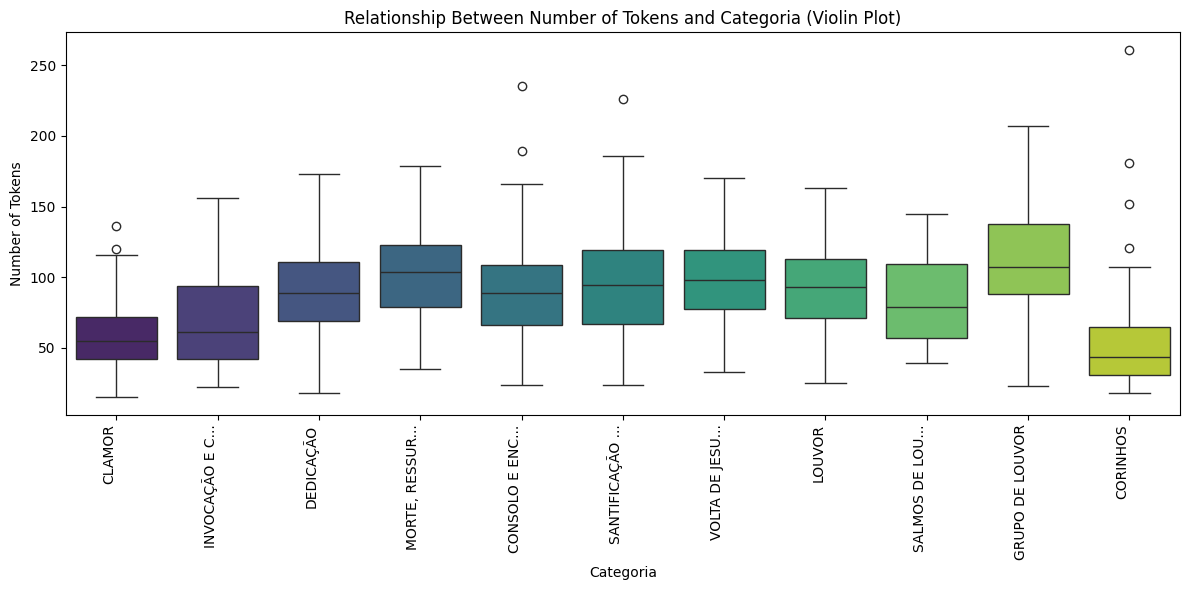

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'categoria_id' is treated as a categorical variable
hinos_analise["categoria_id"] = hinos_analise["categoria_id"].astype("category")

# Create a mapping between categoria_id and categoria
categoria_mapping = (
    hinos_analise[["categoria_id", "categoria_abr"]]
    .drop_duplicates()
    .set_index("categoria_id")["categoria_abr"]
)

# Create a violin plot
plt.figure(figsize=(12, 6))
""" sns.violinplot(
    data=hinos_analise,
    x="categoria_id",
    y="num_tokens",
    palette="viridis",
    inner="quartile",
) """
sns.boxplot(data=hinos_analise, x='categoria_id', y='num_tokens', palette='viridis')

# Replace x-ticks with corresponding 'categoria' names
plt.xticks(
    ticks=range(len(categoria_mapping)),
    labels=categoria_mapping,
    rotation=90,
    ha="right",
)

# Add labels and title
plt.xlabel("Categoria")
plt.ylabel("Number of Tokens")
plt.title("Relationship Between Number of Tokens and Categoria (Violin Plot)")

# Show the plot
plt.tight_layout()
plt.show()

## Word length (maybe)

- bag-of-words with frequency + word map
- gensim corpus
- tf-idf
- named entity recognition (spacy or polyglot)

In [89]:
tokenized_lines = hinos_analise.iloc[0]["tokens_no_stops"]
tokenized_lines[:10]

['TUDO',
 'DEVO',
 'GRAÇA',
 'VÊ',
 'CERTO',
 'VOU',
 'GLÓRIA',
 'CRISTO',
 'VIVER',
 'MARANATA']

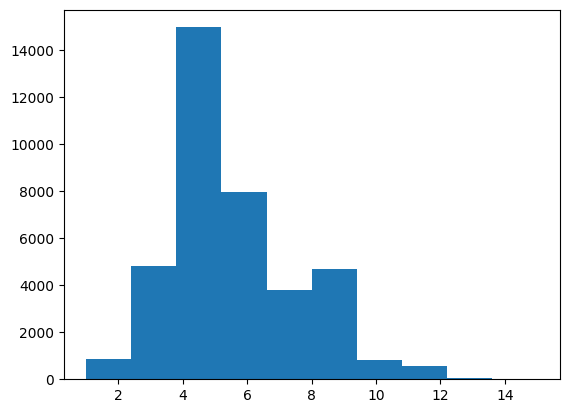

In [90]:
# Make a frequency list of lengths: line_num_words
line_num_words = [len(t_line) for t_line in hinos_analise["tokens_no_stops"].explode().tolist()]

# Plot a histogram of the line lengths
plt.hist(line_num_words)

# Show the plot
plt.show()

## Palavras

In [91]:
palavras = hinos_analise["tokens_no_stops"].explode().tolist()
palavras = [palavra for palavra in palavras if "CORO" not in palavra]

### Palavras mais longas

In [92]:
# find the 10 largest words
palavras_unique = list(set(palavras))
palavras_unique.sort(key=len, reverse=True)
print(len(palavras_unique))
pd.DataFrame({
    "palavra": palavras_unique[:10],
    "tamanho": [len(palavra) for palavra in palavras_unique[:10]]
})

4629


,palavra,tamanho
0,ESPIRITUALMENTE,15
1,SOBRECARREGADOS,15
2,RESPLANDECENTE,14
3,SOBRECARREGADO,14
4,CARINHOSAMENTE,14
5,REVERENTEMENTE,14
6,PROPORCIONANDO,14
7,CIRCUNSTÂNCIAS,14
8,TRANSFORMANDO,13
9,TRANSFORMADOS,13


### Bag-of-words with frequency

In [93]:
print(len(palavras))
set_words_full = list(set(palavras))
count_words = [palavras.count(i) for i in set_words_full]

contagem_palav = pd.DataFrame(
    zip(set_words_full, count_words), columns=["palavra", "contagem"]
)
contagem_palav = contagem_palav.sort_values("contagem", ascending=False)
contagem_palav

38477


,palavra,contagem
3145,JESUS,1362
1926,SENHOR,1214
3054,DEUS,869
3158,AMOR,614
2412,GLÓRIA,492
...,...,...
4605,SUPLICA,1
4607,SURGIA,1
4609,SAULO,1
4611,COMEÇAM,1


In [94]:
# create a percentage column
contagem_palav["percentual"] = contagem_palav["contagem"] / len(palavras) * 100
contagem_palav

,palavra,contagem,percentual
3145,JESUS,1362,3.539777
1926,SENHOR,1214,3.155132
3054,DEUS,869,2.258492
3158,AMOR,614,1.595759
2412,GLÓRIA,492,1.278686
...,...,...,...
4605,SUPLICA,1,0.002599
4607,SURGIA,1,0.002599
4609,SAULO,1,0.002599
4611,COMEÇAM,1,0.002599


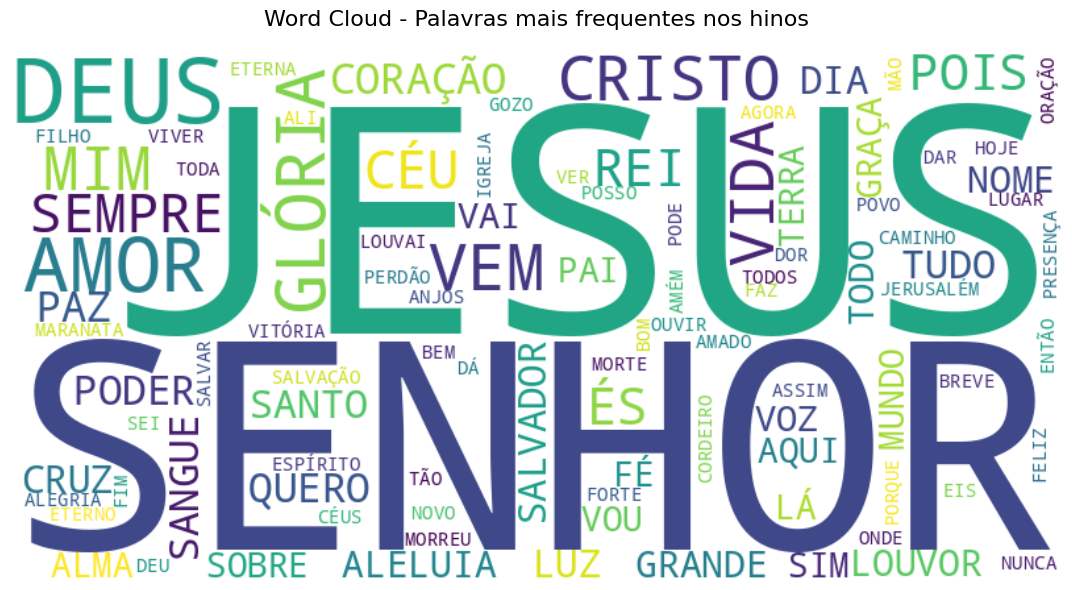

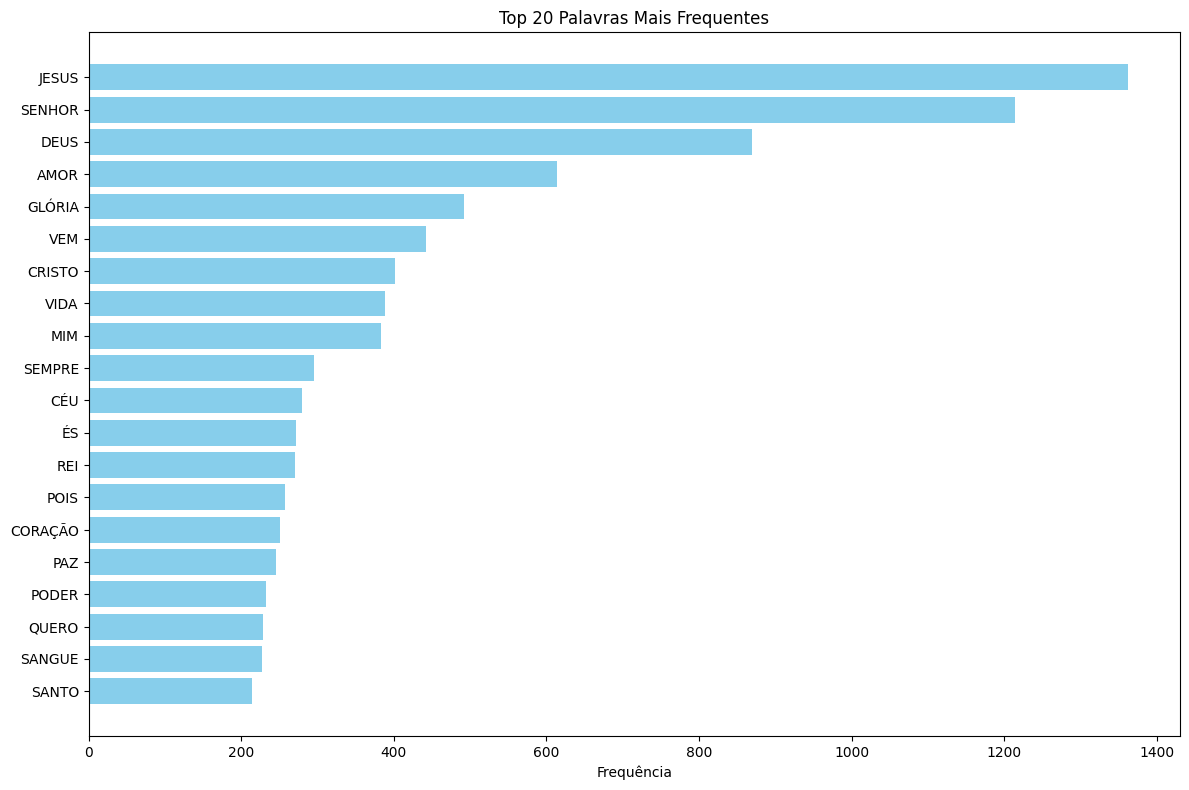

In [95]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary from the word frequency data
word_freq_dict = dict(zip(contagem_palav['palavra'], contagem_palav['contagem']))

# Generate word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    max_words=100,
    colormap='viridis',
    relative_scaling=0.5,
    random_state=42
).generate_from_frequencies(word_freq_dict)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Palavras mais frequentes nos hinos', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Also show top 20 most frequent words as a bar chart
plt.figure(figsize=(12, 8))
top_20 = contagem_palav.head(20)
plt.barh(range(len(top_20)), top_20['contagem'], color='skyblue')
plt.yticks(range(len(top_20)), top_20['palavra'])
plt.xlabel('Frequência')
plt.title('Top 20 Palavras Mais Frequentes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()